#Preliminary Analyses of Tweets on Rebel Groups in Syria

<B>Laila Wahedi</B>

Below is part of an exploratory analysis on tweets from rebel groups in Syria. The intent was to play with and understand the data, to get a sense of what inferences might be drawn.

<b>Import necessary packages,</b> set working directory, and initialize a progress bar for slow processes
<br>
Note, there exist several versions of oauth2, and they don't all seem to work. I'm not sure why, but stack overflow is full of people with a similar problem. I installed twitter_oauth and used the version of oauth2 within that. urllib to translate search terms to what the API can interpret. json to read the twitter output. Math and time so I can round down when spacing out calls to stay within the rate limit. Numpy for arrays.

In [32]:
import httplib2
import oauth2 as oauth
import urllib
import json
import numpy
import scipy
import time
import sys
import rpy2
import math
from itertools import izip, groupby
from IPython.display import clear_output
import uuid
from IPython.display import HTML, Javascript, display
import re

%load_ext rpy2.ipython
%R library(foreign)
%R library(grid)
%R library(ggplot2)
%matplotlib inline
%R library(outliers)
%R library(cluster)
%R library(fpc)
%R library(graphics)
%R library(igraph)
%R library("aod")

workingDir='C:\\Users\\Laila\\Desktop\\ISISTweets'
%R setwd("C:\\Users\\Laila\\Desktop\\ISISTweets")
divid = str(uuid.uuid4())
pb = HTML(
"""
<div style="border: 1px solid black; width:500px">
  <div id="%s" style="background-color:blue; width:0%%">&nbsp;</div>
</div> 
""" % divid)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#Pull Twitter Data

### Insert your actual access and consumer twitter keys and secrets, and your working directory below

This section also pulls in the serch terms and saves them in <b>terms</b>

In [ ]:
consumerKey='XXXX' 
consumerSecret='XXXX'
accessToken='XXXX'
accessSecret='XXXX'
workingDir='C:\Users\Laila\Desktop\ISISTweets'
termFile=open(workingDir + '\Terms.txt','r')
terms=termFile.read().splitlines()
termFile.close()

The following 3 lines were adapted from the twitter development page, but were modified.
https://dev.twitter.com/oauth/overview/single-user
Creates a Client used for authenication when making requests from Twitter

In [ ]:
consumer = oauth.Consumer(key=consumerKey, secret=consumerSecret)
token = oauth.Token(key=accessToken, secret=accessSecret)
client = oauth.Client(consumer, token)

<b>This section takes search terms from a file, url encodes them, and makes a request to the search API for each search term, decodes json into a python dictionary, then stores it in output variable. It also stores each pull in a text file.</b>
<b>terms:</b> List of all search terms. Pulled from Terms.txt above. 
<b>url:</b> stores the beginning part of url used to request from the API<br>
<b>rawOutput</b> is a list of lists, each containing a list of the dictionary of results for each search term.<br>
<b>for loop 1:</b> Each call can only collect 100 tweets, and Twitter rate limits to 180 calls per 15 minute period. The first for loop runs every 15 minutes and 5 second to stay within the rate limit. It runs for about five hours.<br>
<b>for loop 2:</b> Loops 7 times so that I make 180 calls within every 15 minute period. <br>
<b>for loop 3:</b> Loops through each search term. <br>
<b>useURL</b> is the full url with the search term encoded. count requests 100 tweets, <b>max_id</b> is a way to index so that each call pulls the next 100 tweets from the search results.<br>
<b>client.request</b> makes the actual request to the Twitter API, using the credentials stored in client. This is done withing a for loop so that I can retry when connection errors occur, but not so many times as to get my IP blacklisted by Twitter. <br>
Each request is saved in a text file, and is written to rawOutput which is the main data object used by the script. <br>
Note: the original dataset only had 5 attributes per tweet, but I am collecting all the attributes available in a Tweet. 

In [ ]:
url='https://api.twitter.com/1.1/search/tweets.json?'
rawOutput=[]
max_ids=[]
iteration= 0
for period in range(0,20):
    for rep in range(0,int(math.floor(180/len(terms)))):#7 times per 15min
        termCount=0
        for index, term in enumerate(terms):
            if iteration==0:#don't have a max_id on the first iteration
                urlUse=(url+urllib.urlencode({'q' : term})+'&count='+str(100))
                rawOutput.append([])
                max_ids.append([])
            else:
                urlUse=(url+urllib.urlencode({'q' : term})+\
                        '&count='+str(100)+'&max_id='+str(max_ids[termCount]-1))
            for i in range(0,4): #to catch and retry when there are errors
                try:
                    pull=client.request(urlUse)[1]#collect the data
                except Exception:
                    print 'error'
                    time.sleep(15)
                    pass
                else:
                    break
            fileName = "{}_{}_{}.txt".format(str(period),str(rep),str(index))
            with open(workingDir + "\pulls\\" + fileName, "w") as file:
                file.write(pull)
            rawOutput[termCount]+=[json.loads(pull)]
            #Remember the last tweet in max_id:
            max_ids[termCount]=rawOutput[termCount][iteration]['search_metadata']['max_id']
            termCount+=1
        iteration+=1
    time.sleep(15*60+5) #wait fifteen minutes
print 'done'
%store rawOutput #save the workspace, just in case

##Load Data
<b>Restore from text files</b><br>
So that you don't have to query Twitter again.<br>
Cycle through each term, time period, and repetition in order to recreate the string, pull the file in, and decode it from json. Store in rawOutput.<br>
Won't work if there are missing files, so create placeholders if there are. 
<b>adjust period and rep ranges if some of the files are removed</b><br>
<b>This is slow and requires a lot of memory, so you can also try %store -r to bring rawOutput back from the notebook memory.</b> Alternatively, change period to iterate through 5 periods to use a subset of the data.

In [ ]:
rawOutput=[]
for term in range(0,len(terms)):
    rawOutput.append([])
for period in range(0,20):
    #There was an error and the 7 batch wasn't downloaded
    if period == 7:
        continue 
    for rep in range(0,7):
        for t in range(0,23):
            #inset opening the file
            fileName = "{}_{}_{}.txt".format(str(period),str(rep),str(t))
            with open(workingDir + "\pulls\\" + fileName, "r") as file:
                pull=file.read()
            rawOutput[t].append(json.loads(pull))
print 'done'

In [ ]:
%store -r

<b>Import Lisa's ISIS tweet data, split each string into a list.</b><br>
decode in order to handle arabic script when splitting by ascii delimeter

In [ ]:
isisFile=open(workingDir + '\isis_tweets.txt','r')
isisTweets=file.read(isisFile).splitlines()
isisFile.close()
for index in range(0,len(isisTweets)):
    isisTweets[index]=isisTweets[index].decode('utf8').split(u"\u001F")

##Clean and Structure Data
###Test quality of original dataset
<b>errorList:</b> list of 7 lists, one for each of the 5 variable in the original dataset: hashtag, user, id, time, tweet. One for if there are more than 5 elements, which would suggest a decoding error, and one for if there is more than one of the five variables missing. Holds the id of any item in which the value is missing<br>
Note: the error list for the fifth variable is a catchall for not having found anything wrong with the first four when there's still a missing variable. <br>
<b>Result:</b> Nothing missing, which makes sense, given how scrubbed the data was. 

In [ ]:
errorList=[[],[],[],[],[],[],[]]
index=0
for tweet in isisTweets:
    if len(tweet)==4:
        if tweet[0]=='#isis':
            if tweet[1][1]=='@':
                if len(tweet[2])==18:
                    if tweet[3][0:4]=='2014':
                        errorList[4].append(index)
                    else:
                        errorList[3].append(index)
                else:
                    errorList[2].append(index)
            else:
                errorList[1].append(index)
        else:
            errorList[0].append(index)
    elif len(tweet)>5:
        errorList[5].append(index)
    elif len(tweet)<4:
        errorList[6].append(index)
    index+=1
    
print '1:', len(errorList[0]), ' 2:', len(errorList[1]), \
        ' 3:', len(errorList[2]), ' 4:', len(errorList[3]), \
       ' 5:', len(errorList[4]),' 6:', len(errorList[5]), ' 7:',\
        len(errorList[6])

<b>Test completeness of collected data</b> <br>
Tweets contain many attributes that can be null. I will check for the presence of several attributes of interest. Since these attributes are generated by the api, they are likely to be valid if present.<br>
When the tweet is missing, meaning there were no more relevant tweets provided by the api, all fields are recorded as missing.<br>
0) contributor id: the unique id for a given user. Should be an int or long.<br>
1) coordinates: location, longitude then latitude of tweet origin. Check if null<br>
2) hashtags: list of hashtags on a tweet. Check if empty. Empty does not mean an error, but this output will give a sense of how many have no hashtags to work with.<br>
3) favorited: how many people "liked" the tweet. check if null.<br>
4) text: text of the tweet, check if empty.<br>
5) language: language of the tweet. Useful for translating later. check if null.<br>
6) reply: user that the tweet replied to. check if null. Absence does not mean an error but this will give a sense of how many are replies.<br>
7) retweet count: how many times the tweet was retweeted by others. Should be int.<br>
8) witheld in countries: list of countries banning this tweet. check if null.<br>
For loop 1: cycle through each term <br>
for loop 2: Cycle through each data pull (number stored in iteration)<br>
for loop 3: cycle through each tweet in a pull<br>
Check for the presence of each item, count if it's missing. Keep track of number of missing by search term.
<b>result: </b>Lots of missingness in certain attributes such as coordinates. Also, several of the search terms have fewer tweets than there were pulls, resulting in high missingness under the tweet id category for some search terms.

In [ ]:
missingInTerm=[]
for termInd in range(0,len(terms)):
    numMissing=[0,0,0,0,0,0,0,0,0]
    for pull in range(0,5*7):
        for tweet in range(0,100):
            try: 
                rawOutput[termInd][pull]['statuses'][tweet]['user']['id']
                pass
            except:
                numMissing=[m+1 for m in numMissing]
                continue
            if type(rawOutput[termInd][pull]['statuses'][tweet]['user']['id'])==int or long:
                pass
            else:
                numMissing[0]+=1
            if not rawOutput[termInd][pull]['statuses'][tweet]['coordinates']:
                numMissing[1]+=1
            if not rawOutput[termInd][pull]['statuses'][tweet]['entities']['hashtags']:
                numMissing[2]+=1
            if 'favorite_count' not in rawOutput[termInd][pull]['statuses'][tweet]:
                numMissing[3]+=1
            if not rawOutput[termInd][pull]['statuses'][tweet]['text']:
                numMissing[4]+=1
            if 'lang' not in rawOutput[termInd][pull]['statuses'][tweet]:
                numMissing[5]+=1
            if 'in_reply_to_user_id' not in rawOutput[termInd][pull]['statuses'][tweet]:
                numMissing[6]+=1
            if type(rawOutput[termInd][pull]['statuses'][tweet]['retweet_count'])!=int:
                numMissing[7]+=1
            if'withheld_in_countries' not in rawOutput[termInd][pull]['statuses'][tweet]:
                numMissing[8]+=1            
    missingInTerm.append(numMissing)
for term in range(0,len(terms)):
    print 'term: ', missingInTerm[term]

<b>Pull out some useful variables,</b> <br>
1)Tweet text <br>
2)Tweet ID <br>
3)user ID <br>

In [ ]:
textAll=[]
tweetIDAll=[]
userIDAll=[]
for termInd in range(0,len(terms)):
    textAll.append([])
    tweetIDAll.append([])
    userIDAll.append([])
    for pull in range(0,len(rawOutput[0])):
        for tweet in range(0,100):
            try:
                rawOutput[termInd][pull]\
                ['statuses'][tweet]['id']
            except:
                continue
            textAll[termInd].append(rawOutput\
                                    [termInd][pull]\
                                    ['statuses']\
                                    [tweet]['text'])
            tweetIDAll[termInd].append(rawOutput\
                                       [termInd][pull]\
                                       ['statuses']\
                                       [tweet]['id'])
            userIDAll[termInd].append(rawOutput\
                                      [termInd][pull]\
                                      ['statuses']\
                                      [tweet]['user']\
                                      ['id'])

<b>Check for Redundancy</b><br>
Assess separately for each search term. (for loop 1) <br>
Count the number of tweets for a term, and the number of unique tweets<br>
While I'm at it, also create an index of the sorted tweets, and a list of the index of all the duplicates so they can be deleted later. <br>
<b>Results: </b> Turns out there was a lot of redundency. I need to find another way to scroll through the timeline, since it does not appear to be chronological, which means the pagination method suggested by the dev page does not work. 

In [ ]:
uniqueCount=[]#count of unique tweets
totalCount=[]#count of tweets
sortIndex=[]#index of sorted tweets
keepIndex=[]#unique tweet index
for t in range(0,len(terms)):#for each term
    #unique and total tweets for term
    unique=1
    total=1
    keep=[]
    #sort the tweets chronologically then create index
    tweets=sorted(tweetIDAll[t])
    sortInd=sorted(range(0,len(tweetIDAll[t])),\
                   key=lambda x: tweetIDAll[t][x])
    #for each tweet:
    for index, tweet in enumerate(tweets[:-1]):
        total+=1
        #if the tweet is different from next:
        if tweet != tweets[index+1]:
            unique+=1
            keep.append(index)
    #only keep index of unique sorted tweets
    sortIndTemp=[]
    for k in keep:
        sortIndTemp.append(sortInd[k])
    #store vars in lists before moving on
    sortInd=sorted(sortIndTemp)
    uniqueCount.append(unique)
    totalCount.append(total)
    sortIndex.append(sortInd)
    keepIndex.append(keep)
print uniqueCount
print totalCount

###Create Adjacency Matrix (To be used later)
<b>Identify unique users</b><br>
Similar to the loop above, but for users. Stores index of unique values for use in creating the adjacency matrix below. 

In [ ]:
sortUserIndex=[]
keepUserIndex=[]
for t in range(0,len(terms)):#loop through each term
    keep=[]
    #sort users numerically
    users=sorted(userIDAll[t])
    sortInd=sorted(range(0,len(userIDAll[t])),\
                   key=lambda x: userIDAll[t][x])
    #loop through users tweeting this term.
    #if unique, store index
    for index, user in enumerate(users[:-1]):
        if user != users[index+1]:
            keep.append(index)
    #only keep the sorted index of unique users:
    sortIndTemp=[]
    for k in keep:
        sortIndTemp.append(sortInd[k])
    sortInd=sorted(sortIndTemp)#put back in order
    sortUserIndex.append(sortInd)
    keepUserIndex.append(keep)
print 'done'

<b>Import data if this is a new session</b>

<b>Create adjacency matrix<b><br>
Matrix of search results by search results. A given cell gives the number of users who tweeted about both.<br>
1)create lists of users<br>
2)create array<br>
3)compare users, add numbers to array<br>

In [ ]:
#create list of users unique users for each term
usersAll=[]
for t in range(0,len(terms)):#for term
    usersTerm=[]
    for ind in sortUserIndex[t]:#for unique user
        usersTerm.append(userIDAll[t][ind])#store
    usersAll.append(usersTerm)#store in user list
#create array
adjMat=scipy.zeros((len(terms),len(terms)))
#Populate array.
for t1 in range(0,len(terms)):#for term
    for u1 in usersAll[t1]:#for user in term
        #for second dimension of term
        for t2 in range(0,len(terms[t1:])):
            if t1==t2:#skip if diagonol
                continue
            #if user posted about second term
            if u1 in usersAll[t2]:
                adjMat[t1,t2]+=1#store in matrix
                adjMat[t2,t1]+=1#symmetrical
#fill diagonol with total users. 
for t1 in range(0,len(terms)):
    adjMat[t1,t1]=len(usersAll[t1])
#save
numpy.savetxt("userAdjacencyMat.csv", adjMat, delimiter=",")

<b>Process</b>
Pull out text, create index structures of the same shape storing the term, pull, and tweet number. Create another structure to indicate whether the tweet is in English
<br>
Note: Redundant to data extraction above, but useful for when pulling in the extant json files after already having validated and cleaned the data.

In [4]:
text_struct = []
pull_struct = []
tweet_struct = []
lang_struct=[]
print 'starting'
for term in range(0,len(rawOutput)):
    clear_output()
    print term
    print
    text_struct.append([])
    pull_struct.append([])
    tweet_struct.append([])
    lang_struct.append([])
    for pull in range(0,len(rawOutput[term])):
        for tweet in range(0,len(rawOutput[term][pull]['statuses'])):
            text_struct[term].append(rawOutput[term][pull]['statuses'][tweet]['text'])
            if rawOutput[term][pull]['statuses'][tweet]['lang'] == 'en':
                lang_struct[term].append(1)
            else:
                lang_struct[term].append(0)
            pull_struct[term].append(pull)
            tweet_struct[term].append(tweet)

22



<b>Check how much english there is: </b>

In [6]:
for i in range(0,23):
    print sum(lang_struct[i]), ' of ', len(lang_struct[i])

3273  of  3455
647  of  755
303  of  356
137  of  142
222  of  225
168  of  200
11  of  12
191  of  273
14  of  16
98  of  99
4  of  4
2338  of  3191
9388  of  13379
201  of  208
11960  of  14000
4  of  28
230  of  398
11575  of  14000
12966  of  14000
2753  of  3720
12231  of  14000
8706  of  14000
494  of  569


<b>Remove non-english tweets from my dataset</b>
<br>
The majority of the tweets are in English, so at this stage it's safe to exclude the rest. The Google API charges now, and the Bing API doesn't detect the language, so until I figure out how to translate, I'll exclude the non-English tweets
Create a list for each term containing all english tweets, and corresponding index lists. 

In [5]:
text_structE  = []
pull_structE  = []
tweet_structE = []
for term in range(0,len(text_struct)):
    text_structE.append([val for i,val in izip(lang_struct[term], text_struct[term]) if i])
    pull_structE.append([val for i,val in izip(lang_struct[term], pull_struct[term]) if i])
    tweet_structE.append([val for i,val in izip(lang_struct[term], tweet_struct[term]) if i])


<b>Remove duplicates</b> from Lisa's dataset, then pull out the text to prepare for sentiment analysis. Store text in itweetText. 

In [10]:
isisTweets.sort()
isisTweetsUnique=list(isisTweets for isisTweets, var in groupby(isisTweets))
print(str(len(isisTweets)-len(isisTweetsUnique)) + ' removed')

itweetText=[]
for tweet in isisTweetsUnique:
    itweetText.append(tweet[4])

226592 removed


# Exploratory Analyses

### Sentiment/Affect-Valence Analysis

<b>clean text for sentiment analysis.</b><br>
-Clean words. <br>
-Remove numerals and punctuation <br>
-Pass into R for analysis. <br>
Separate cells for my data and original data so they can be run separately and input separately. It's easier to separate the analysis since they have slightly different structures. 

In [7]:
text_structEC=text_structE

print 'cleaning tweets'
for term in range(0,len(text_structE)):
    clear_output()
    print term
    for tweet in range(0,len(text_structEC[term])):
        text_structEC[term][tweet]=re.sub(r"'", r"", text_structEC[term][tweet])
        text_structEC[term][tweet]=re.sub(r'[\W\d]', r' ', text_structEC[term][tweet])
   
%R text_structEC<-list()
for term in range(0,len(text_structEC)):
    v = text_structEC[term]
    %R -i v
    %R -i term
    %R text_structEC[[term+1]]<-v

22


In [ ]:
itweetTextC=itweetText
for tweet in range(0,len(itweetTextC)):
    itweetTextC[tweet]=re.sub(r"'", r"", itweetTextC[tweet])
    itweetTextC[tweet]=re.sub(r'[\W\d]', r' ', itweetTextC[tweet])

<b>Workaround for rpy2</b><br>
Python crashes every time I try to transfer the isis tweet text into R, so I have a manual workaround. <br>
1) write it to a text file, <br>
2) manually change the extention to .csv, <br>
3) import to R in R itself, (still crashes when importing through rpy2)<br>
4) save the file as a .RData <br>
5) import. rpy2 is really buggy, and executing the same commands into ipython using rpy2 crashes the notebook. <br>
<b>Do not need to run this code</b> because the file should already be saved.
<br>Note: in the future, use Beaker Objects

In [13]:
itweetText=[]
isisTweets=[]
with open(workingDir+'\\isisTweetWords.txt','w') as file:
    for item in itweetTextC:
        file.write(item+'\n')

open


Change extension to .csv, and execute the following lines in R itself:
<br>isisTwitterWords<-read.csv('C:\\Users\\Laila\\Desktop\\ISISTweets\\isisTweetWords.csv', headers=FALSE)
<br>tweetWords<-tweetWords[[1]]
<br>tweetWords<- data.frame(lapply(tweetWords, as.character), stringsAsFactors=FALSE)<br>
<i><u>From:</u> http://stackoverflow.com/questions/2851015/convert-data-frame-columns-from-factors-to-characters </i>
<br>save(itweetWords, file = 'C:\\Users\\Laila\\Desktop\\ISISTweets\\isisTweetWords.RData')
<br>Then import the rdata file.<br> 
Note, entering the above into rpy2, does not work. I tried:
<br><u>Try 1: </u>
<br>%R -i itweetTextC
<br><u>Try 2:</u>
<br> %R itweetWords<- read.csv ('C:\\Users\\Laila\\Desktop\\ISISTweets\\isisTweetWords.csv', header=FALSE)

In [8]:
%R load("isisTweetWords.RData", verbose=FALSE)

array(['itweetWords'], 
      dtype='|S11')

<b>Sentiment Analysis (pt 1)</b><br>

Import the affect dictionary. Taken from:<br>
<i>Warriner, A.B., Kuperman, V., & Brysbaert, M. (2013). Norms of valence, arousal, and dominance for 13,915 English lemmas. Behavior Research Methods, 45, 1191-1207.</i><br><br>
<u>Warning:</u> Rpy2 on windows does not actually show you most of the output from R, you have to store it in variables and pull them back into python. No clue what the output will look like on a mac. In fact, it's so buggy on windows and I've had to do so many workarounds, I have no clue how this will run on a mac at all.<br>
<u>Process</u><br>
1) Pull in affect dictionary<br>
2) loop through terms, tweets, and words.<br>
3) if the word is in the dictionary, store the affect rating<br>
4) text_struct_affect contains a list for each term. Each term has a list of tweets, each tweet has a list of affect ratings. 

In [460]:
%%R 
affDict<-read.csv("affectDict.csv",header=TRUE,row.names=1)

text_struct_affect <- list()
for (term in 1:length(text_structEC)) {
  termList <-list()
  for (tweet in 1:length(text_structEC[[term]])){
      TwordList<-unlist(strsplit(text_structEC[[term]][tweet], '[ ]'))
      TaffectList<- list()
      for (word in 1:length(TwordList)){
        if(!is.na(affDict[tolower(TwordList[[word]]),])){
            TaffectList[[length(TaffectList)+1]]<-affDict[tolower(TwordList[[word]]),]
        }
      }
      if(length(TaffectList)>0){termList[[tweet]]=TaffectList}
  }
  text_struct_affect[[term]]<-termList
}

<b>Sentiment Analysis (Pt 2)</b><br>
-loop through tweets, and words.<br>
-if the word is in the dictionary, store the affect rating<br>
-iTweets (for isisTweets, the original dataset) contains a list of affect ratings for each tweet<br>
-<u>Note</u>: This takes a <i>really</i> long time to run, so I usually run it on a subset. To change the size of this subset on line 2. I'm not sure it will work with the whole dataset, because I run out of memory in the workspace as it is. Parallel process with subsets on separate notebooks instances.

In [461]:
%%R
subS<-10000
iTweets <-list()
for (tweet in 1:length(itweetWords[1:subS])) {
    TwordList<-unlist(strsplit(itweetWords[tweet][[1]],'[ ]'))
    TaffectList<-list()
    for (word in 1:length(TwordList)) {
        if(!is.na(affDict[tolower(TwordList[[word]]),])){
          TaffectList[[length(TaffectList)+1]]<-affDict[tolower(TwordList[[word]]),]}
    }
    if(length(TaffectList)>0){iTweets[[tweet]]=TaffectList}
}

#### Bin each word's affect by valence:

Create data frame for each search term and the original data with a row for each tweet, and a column for each binning of affect, from very negative to very positive. For a given row/tweet, add one to binning column for every word within that category. Include one more row for the total number of words, and divide the rest by this number at the end. <br>
<b>clustVar:</b> list of dataframes, one for each search term. One for the original twitter data.
<b>data frames:</b>The rows are: number of tweets. The columns are: very negative, moderately negative, neutral, moderately positive, very positive. Each cell shows the percentage of words in a given tweet that falls in that category. Row has all zeros if none of the words could be classified. This is especially prevalent in the original data, where many of the tweets aren't in english. This could not be sorted out ahead of time because the google translate API costs money now, and the the original dataset did not include the information

In [462]:
%%R
clusterVar=list()
colNms=c('vneg','mneg','nt','mpos','vpos','tot','val')
for(term in 1:length(text_struct_affect)){
    tmpMat=matrix(0,length(text_struct_affect[[term]]),7)
    TermClustVars=data.frame(tmpMat)
    colnames(TermClustVars)<-colNms
    for(tweet in 1:length(text_struct_affect[[term]])){
        tmpVect<-c(0,0,0,0,0,0,0)
        if (length(text_struct_affect[[term]][[tweet]])>0){
        for (el in 1:length(text_struct_affect[[term]][[tweet]])){
            val<-text_struct_affect[[term]][[tweet]][[el]]
            tmpVect[7]=tmpVect[7]+val
            if(val<=-2){tmpVect[c(1,6)]=tmpVect[c(1,6)]+1
            } else if(val<=-.5){tmpVect[c(2,6)]=tmpVect[c(2,6)]+1
            } else if(val<=.5){tmpVect[c(3,6)]=tmpVect[c(3,6)]+1
            } else if(val<=2){tmpVect[c(4,6)]=tmpVect[c(4,6)]+1
            } else if(val<=5){tmpVect[c(5,6)]=tmpVect[c(5,6)]+1}
        }
        tmpVect[1:5]<-tmpVect[1:5]/tmpVect[6]}
        TermClustVars[tweet,]<-tmpVect
    }
    clusterVar[[term]]<-TermClustVars
}

In [463]:
%%R
tmpMat=matrix(0,length(iTweets),7)
iClustVars=data.frame(tmpMat)
colNms=c('vneg','mneg','nt','mpos','vpos','tot','val')
colnames(iClustVars)<-colNms
for(tweet in 1:length(iTweets)){
    tmpVect<-c(0,0,0,0,0,0,0)
    if (length(iTweets[[tweet]])>0){
    for (el in 1:length(iTweets[[tweet]])){
        val<-iTweets[[tweet]][[el]]
        tmpVect[7]=tmpVect[7]+val
        if(val<=-2){tmpVect[c(1,6)]=tmpVect[c(1,6)]+1
        } else if(val<=-.5){tmpVect[c(2,6)]=tmpVect[c(2,6)]+1
        } else if(val<=.5){tmpVect[c(3,6)]=tmpVect[c(3,6)]+1
        } else if(val<=2){tmpVect[c(4,6)]=tmpVect[c(4,6)]+1
        } else if(val<=5){tmpVect[c(5,6)]=tmpVect[c(5,6)]+1}
    }
    tmpVect[1:5]<-tmpVect[1:5]/tmpVect[6] }
    iClustVars[tweet,]<-tmpVect
}
clusterVar[[length(text_struct_affect)+1]]<-iClustVars

<b>Checkpoint:</b> <br>
Save R workspace so you don't have to run the above code each time. <br>
Rpy2 crashes a lot, so this checkpoint is important.

In [465]:
%%R 
save.image(file="checkpoint.RData")

<b>Load Checkpoint</b>

In [1]:
%%R 
load("checkpoint.RData")

### Summary Statistics

<b>Prepare to run summary stats on clusterVar dataframes</b>
<br>Create a function for easy plotting, taken from the R cookbook:
<br><i>http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/</i>
<br>Make sure you have all the dependencies of ggplot2 installed. It errors out if you don't.

In [467]:
%%R
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

<b>Summary Statistics</b> for each search term, and the original dataset.<br>
-Look at the average calculated valence for each tweet. <br>
-Look at histograms to find outliers. <br>
-Perform grubbs test to identify outliers<br><br>

<u>Note</u>: rpy2 doesn't print into the notebook, at least not on a windows machine, so I'm storing the output in sumList and outlierList, passing it to python and printing it in the next cell.

In [468]:
%%R
sumList<-list()
Hplots<-list()
outlierList<-list()

for (term in 1:length(clusterVar)){
    Hplots[[term]]<-qplot(clusterVar[[term]]$'val', xlab = term, geom="histogram")
    sumList[[term]]<-capture.output(summary(clusterVar[[term]]['val']))
    outlierList[[term]]<-grubbs.test(clusterVar[[term]]$'val',two.sided=TRUE)
}


<b>View Summary Statistics</b><br>
The original tweets are stored in number 24, the rest are the search terms from my data. 

In [469]:
%R -o sumList
print sumList

Unable to unlink tempfile c:\users\laila\appdata\local\temp\tmpbvvuxc
[[1]]

[1] "      val         " " Min.   :-11.830  " " 1st Qu.:  2.270  "

[4] " Median :  3.580  " " Mean   :  3.592  " " 3rd Qu.:  5.510  "

[7] " Max.   : 15.160  "



[[2]]

[1] "      val       " " Min.   :-5.19  " " 1st Qu.: 0.04  " " Median : 1.26  "

[5] " Mean   : 1.82  " " 3rd Qu.: 3.59  " " Max.   :13.91  "



[[3]]

[1] "      val         " " Min.   :-6.9500  " " 1st Qu.:-1.4000  "

[4] " Median :-0.1200  " " Mean   : 0.1445  " " 3rd Qu.: 2.4900  "

[7] " Max.   : 7.8200  "



[[4]]

[1] "      val         " " Min.   :-7.1400  " " 1st Qu.:-2.7600  "

[4] " Median :-0.5400  " " Mean   :-0.9162  " " 3rd Qu.: 0.8600  "

[7] " Max.   : 8.2400  "



[[5]]

[1] "      val         " " Min.   :-6.1100  " " 1st Qu.: 1.0300  "

[4] " Median : 1.0300  " " Mean   : 0.9296  " " 3rd Qu.: 1.0300  "

[7] " Max.   : 5.4200  "



[[6]]

[1] "      val        " " Min.   :-2.990  " " 1st Qu.: 1.070  "

[4] " Median : 3.390  

<b>Summary Discussion</b><br>
With few exceptions, the valence tends to be positive. This is interesting especially because the valence dictionary is slightly skewed negative, and all these tweets are about terrorist groups. If the sentiment analysis is picking up on what I hope it's picking up on, this may suggest that more supporters tweet about a search term than detractors. I won't be sure that this is the case until I've hand coded a training set, at which point I'll be able to use a machine learning algorithm. <br>
The means also tend to be pretty close to the medians, which is a first cut look suggesting that the distributions are likely not skewed.<br><br>
Although I plan to eventually use a machine learning algorithm, this valence analysis is still useful. It would be interesting to explore the valence of the language used by supporters and detractors, to see if it systematically differs.  I have a script that does this in matlab, and produces some cool heatmaps. The valence patterns can be correlated with Lisa's new ISIS tweet sentiment training set.

<b>View Outliers</b>

In [470]:
%R -o outlierList
print outlierList

Unable to unlink tempfile c:\users\laila\appdata\local\temp\tmpbxeyfv
[[1]]



	Grubbs test for one outlier



data:  clusterVar[[term]]$val

G = 4.8151, U = 0.9929, p-value = 0.004621

alternative hypothesis: lowest value -11.83 is an outlier





[[2]]



	Grubbs test for one outlier



data:  clusterVar[[term]]$val

G = 4.3936, U = 0.9701, p-value = 0.006231

alternative hypothesis: highest value 13.91 is an outlier





[[3]]



	Grubbs test for one outlier



data:  clusterVar[[term]]$val

G = 3.151, U = 0.967, p-value = 0.4543

alternative hypothesis: highest value 7.82 is an outlier





[[4]]



	Grubbs test for one outlier



data:  clusterVar[[term]]$val

G = 3.2130, U = 0.9235, p-value = 0.1468

alternative hypothesis: highest value 8.24 is an outlier





[[5]]



	Grubbs test for one outlier



data:  clusterVar[[term]]$val

G = 5.6064, U = 0.8571, p-value = 1.329e-06

alternative hypothesis: lowest value -6.11 is an outlier





[[6]]



	Grubbs test for one outlier



da

<b>Outlier Discussion:</b><br>
Most of the terms appear to have at least one outlier. Exceptions are:
<br>3, 6, 9, 16, 17, 20, 23, and possibly 4.<br>
For my analysis I think that's okay, but if I wanted to remove them, I would remove each outlier and then re-run the test to identify additional outliers. 

<b>Histograms for each term's valence</b><br>
Number 24 is the original dataset, 1-23 are the search terms that correspond to the terms in the text file in the working directory.<br>
Repated multiplot line twice so that it would save and print below. Sizing is much better in the saved image. But note, it only plots sometimes. I don't know why. Also note that the plot below only plots sometimes. It's another rpy2 bug that's pretty common. If it doesn't, try another couple times and it might. The jpeg <i>should</i> populate either way.
<br> This is a good first view, but the matlab heatmaps are more telling.

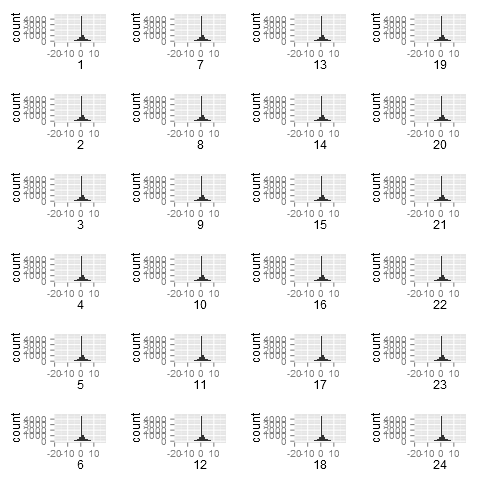

In [472]:
%%R 
jpeg(filename = "histFig.jpg", width= 1600, height= 2400, pointsize =12, quality = 400, bg = "white", res = NA, restoreConsole = TRUE) 
multiplot(plotlist=Hplots,cols=4)
dev.off()
multiplot(plotlist=Hplots,cols=4)

<b>Free memory</b><br>
About out of available memory in rpy2, and the next step takes a lot, so remove variables no longer needed. Can always pull them back from the previous checkpoint

In [473]:
%%R 
rm(affDict, colNms, el, iClustVars, iTweets, itweetWords,
TaffectList, termClustVars, termList, text_struct_affect,
text_structEC, tmpMat, tmpVect, tweet, TwordList)

<b>Checkpoint 2</b>

In [474]:
%%R 
save.image(file="checkpoint2.RData")

### Clustering

<b>Cluster</b> by the distribution of positive and negative words.<br>
Note: When plotting with clusplot, save to jpeg or rpy2 will crash. <br>
Try:<br>
k-means<br>  -k=4 gave reasonable improvements in clustering subs of squares, but the charts don't look great, which suggests there may not actually be distinct clusters.   <br>
dbscan<br>  -threshold around .37 looked good
hierarchical<br>
<u>Note</u>: terms 7 9 10 11 and 16 are too small, so I skipped them.<br>
<u>Note2</u>: no clue why, but clusplot errors out for term 1. I went through step by step and looked at the data, and it looks the same as the data for the rest of the terms, and it clusters just fine, but it doesn't plot. So I skipped 1.
Note 3: I run out of memory in the workspace when doing this sometimes. I saved the output PDF as clusFigBackUp so that it wouldn't get overwritten with half a try. It runs better in R proper where there aren't as many memory limitations.

In [718]:
%%R
kOut<-list()
kPlots<-list()
dbOut<-list()
dbPlots<-list()
hPlots<-list()
pdf(file = "clusFig.pdf") 
i=0
for(term in 2:24){
    if(term!=7 & term!=9 & term!=10 & term!=11 & term!=16){
    kOut[[term]]<-kmeans(clusterVar[[term]][1:5],4)
    kPlots[[term]]<-data.frame(clusterVar[[term]][1:5], kOut[[term]]$cluster)
    if(term!=1){kPlots[[term]]<-clusplot(kPlots[[term]], kOut[[term]]$cluster)}
    d<-dist(clusterVar[[term]][1:5], method="euclidean")
    hOut<-hclust(d, method="complete")
    hPlots[[term]]<-plot(hOut)
    dbOut[[term]]<-dbscan(clusterVar[[term]][1:5],.37)
    dbPlots[[term]]<-plot(dbOut[[term]],clusterVar[[term]][1:5])
}}
dev.off()


Error: cannot allocate vector of size 336.2 Mb


<b>Clustering Discussion</b><br>
Looking at the dbscan plots is revealing. Most tweets are in one cluster, while tweets that are in corners have their own clusters. These corner tweets are tweets with zero words in a given set of columns, or a high number of words in one column and none in another. This might be an interesting way to look at the data, because these clusters capture extremes. For example, there tend to be clusters scoring high on the very negative attribute, and low everywhere else. These might have more extreme affect than other tweets. Or they only have very few words that were in the affect dictionary. At this point it is hard to tell which. <br>
The kmeans didn't do well, but it's also hard to assess when it is flattened into two dimensions. For example, clustering looks highly overlapped, even when the within sum of squares divided by the total sum of squares is minimized substantially. It is similarly difficult to interpret hierarchical outcomes. When I have a hand coded training data set, I will be able to see if there is anything interesting in these patterns. 

###  Network Analysis

<b>Import  adjacency matrix from before</b>, (unless already in memory)<br>
Merge search terms that are for the same group, such as ISIL and ISIS, and NUSRA and Al-Nusra<br>
Save a version with the diagonals, adjMatD<br>
Create a normalized version, to make a weighted adjacency matrix ready for igraph


In [517]:
%%R
adjMat<-read.csv("userAdjacencyMat.csv", header=FALSE)
adjMat<-as.matrix(adjMat)

#Merge ISIS
adjMat[,18:23]<-rowSums(adjMat[,18:23])
adjMat<-adjMat[,-19:-23]
adjMat[18,]<-colSums(adjMat[18:23,])
adjMat<-adjMat[-19:-23,]

#Merge Nusra
adjMat[,12:17]<-rowSums(adjMat[,12:17])
adjMat<-adjMat[,-13:-17]
adjMat[12,]<-colSums(adjMat[12:17,])
adjMat<-adjMat[-13:-17,]

#Merge Jaysh al-Islam
adjMat[,4:7]<-rowSums(adjMat[,4:7])
adjMat<-adjMat[,-5:-7]
adjMat[4,]<-colSums(adjMat[4:7,])
adjMat<-adjMat[-5:-7,]

adjMatD<-adjMat
for(i in 1:10){adjMat[i,i]=0}

adjMatN<-adjMat/max(adjMat)

tweetGraph<-graph.adjacency(adjMatN,mode="undirected",weighted=TRUE)

<b>Network Analysis</b><br>
Run these analyses:
degree cent<br>
assess degree distribution, plot with hist<br>
betweeness<br>
clustering coef<br>
averages of above<br>
density<br>
diameter<br>
components<br>
k-core<br>
edge betweeness clusters


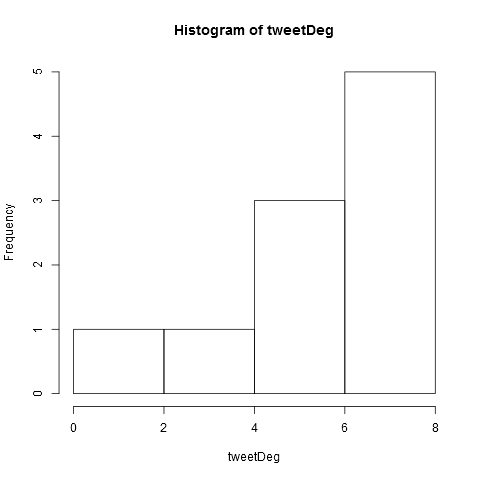

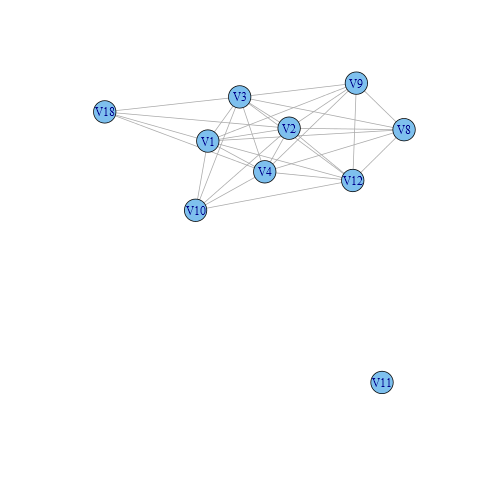

In [719]:
%%R
tweetDeg<-degree(tweetGraph)
hist(tweetDeg)
twtSNA<-data.frame(degree=tweetDeg)
twtDgrDist<-degree.distribution(tweetGraph)

twtSNA$betweenness<-betweenness(tweetGraph,directed=FALSE)
twtSNA$clusterCoef<-transitivity(tweetGraph, type=c("local"))
a<-capture.output(print(summary(twtSNA)))

twtDense<-graph.density(tweetGraph)
twtDiam<-diameter(tweetGraph)

twtComps<-clusters(tweetGraph)
twtCores<-graph.coreness(tweetGraph)
twtClustsEB<-edge.betweenness.community(tweetGraph)
fg<-fastgreedy.community(tweetGraph,merges=TRUE,modularity=TRUE)
twtClustsMod<-community.to.membership(tweetGraph,fg$merges,steps=which.max(fg$modularity)-1)
plot(tweetGraph)

Output:

In [275]:
%R -o a
print a

['     degree      betweenness     clusterCoef    '
 ' Min.   :0.00   Min.   : 0.00   Min.   :0.7857  '
 ' 1st Qu.:5.25   1st Qu.: 0.00   1st Qu.:0.7857  '
 ' Median :6.50   Median : 2.50   Median :0.9048  '
 ' Mean   :6.00   Mean   : 3.80   Mean   :0.8942  '
 ' 3rd Qu.:8.00   3rd Qu.: 5.75   3rd Qu.:1.0000  '
 ' Max.   :8.00   Max.   :15.00   Max.   :1.0000  '
 "                                NA's   :1       "]


The graph is small and dense, with a degree distribution as shown in the histogram above. The graph is dense, so each node has a probability of having many ties given it's size.  Because it is small and dense, it has a small diameter, equal to 0.07641. It is a weighted graph, though, so not all degrees are equally powerful and the diameter does not fully capture the capacity for information to move across the network. <br>
There are two components, the main comonent, and the group in term 11 which is alone.<br>
The average degree is 6, the average betweenness is 2.8, and the average clustering coefficient is .8942, as found in the summary of the twtSNA dataframe. <br>
The largest k-core is made up of groups 1,2,3,4,8,9 and 12. Note that these number indecies are according to their position in the term list, not their position in the adjacency matrix<br>
Edge betweeness put all the groups in the main component in the same cluster, with the singleton 11 in its own cluster. Not a very interesting clustering, but apt. Modularity also put 11 in its own category, put 1 and 18 in a category, and left everyone else out. This is puzzling, since 1 and 2 have similar patterns, and 12 and 18 have similar patterns. I don't think modularity did as well. 


### Correlation

<b>Correlation: Create data</b><br>
Are tweets with a certain affective valence more likely to be retweeted? I will look for correlations between the affective rating, and whether the tweet is a retweet. Retweeted tweets begin with an RT. Another way to do this would be to pull the number of times a tweet was retweeted from my data, but since the original dataset does not have this information, I will use RT. <br><br>
1) free up memory by removing the clustering variables, so that there's space for the text variables
2) load checkpoint 1 to bring back the text structures<br>
3) Loop through each search term, loop through each tweet, if the first word is RT, store a 1, if it is not RT, store a 0. <br>
1) Repeat for original dataset. Loop through tweets, store RT Recall SubS refers to the subsection pulled in when doing the initial sentiment analysis. 


In [543]:
%R ls()

array(['a', 'b', 'c', 'd', 'i', 'j', 'multiplot', 'outlierList', 's',
       'subS', 'sumList', 'term', 'v', 'val', 'word', 'workingDir'], 
      dtype='|S11')

In [ ]:
%R save(hPlots,hOut,Hplots,dbPlots,dbOut,kOut,kPlots, file="clusterData.RData")
%R rm(hPlots,hOut,dbPlots,dbOut,Hplots,kOut,kPlots)

In [540]:
%%R
save(adjMat, adjMatD, adjMatN, tweetDeg, tweetGraph, twtClustsEB,
        twtClustsMod,twtComps, twtCores, twtDense, twtDgrDist, twtDiam,
        twtSNA, file="clusterData.RData")
rm(adjMat, adjMatD, adjMatN, tweetDeg, tweetGraph, twtClustsEB,
        twtClustsMod,twtComps, twtCores, twtDense, twtDgrDist, twtDiam,
        twtSNA, fg)

In [636]:
%%R
load("checkpoint.RData")

In [637]:
%%R
rtVar<-list()
for(term in 1:length(text_structEC)){
    tmpMat=matrix(0,length(text_structEC[[term]]),1)
    rtCol=data.frame(tmpMat)
    colnames(TermClustVars)<-'rt'
    for(tweet in 1:length(text_structEC[[term]])){
        TwordList<-unlist(strsplit(text_structEC[[term]][tweet], '[ ]'))
        rtCol[tweet,]<-TwordList[1]=='RT'
    }
    rtVar[[term]]<-rtCol
}

tmpMat=matrix(0,subS,1)
rtCol=data.frame(tmpMat)
colnames(TermClustVars)<-'rt'
for(tweet in 1:subS){
    TwordList<-unlist(strsplit(itweetWords[tweet][[1]], '[ ]'))
    rtCol[tweet,]<-TwordList[1]=='RT'
}
rtVar[[length(text_structEC)+1]]<-rtCol

In [579]:
%%R 
save(rtVar, file = "rtVariable.RData")

<b>Restructure data for correlation</b><br>
Put values from rtVar and clusterVar in single data frame<br>
Note: clusterVar is a slightly different length than rtVar, because it was built off of the affect variable. For a given term, if the last tweet had no matches in the affect dictionary, it was not included in clusterVar. because these values all had zeros, and we're going to delete the missing values anyway, it's okay to add in place holders. (I manually checked to make sure that the tweets lined up.) 

In [639]:
%%R
reservedClustVar<-clusterVar
print('done')

In [679]:
%%R
clusterVar<-reservedClustVar

In [699]:
%%R
i=0
rtAffectVar<-cbind(rtVar[[1]],clusterVar[[1]])
i=1
for(term in 2:length(clusterVar)){
    if(length(clusterVar[[term]][[1]])!=length(rtVar[[term]][[1]])){
        dif<-length(rtVar[[term]][[1]])-length(clusterVar[[term]][[1]])
        tmpMat<-matrix(0,dif,7)
        colnames(tmpMat)<-colnames(clusterVar[[term]])
        a<-rbind(clusterVar[[term]],tmpMat)
    }
    else{a<-clusterVar[[term]]}
    b<-cbind(rtVar[[term]],a)
    rtAffectVar<-rbind(rtAffectVar,b)
}
rtAffectVarCut<-subset(rtAffectVar, tot>0)
colnames(rtAffectVarCut)<-c('rt','vneg','mneg','nt','mpos','vpos','tot','val')

<b>Correlation</b><br>
1)Set retweet as categorical variable 
2) create logit, and linear models. Exclude one variable as reference variable, because the five add up to 1. Singular if you include them all. Left out the very positive from the logit, and the very negative from the linear model, but you can change them around to explore.
3) store logit display for viewing, move to python, view in another cell (because rpy2 doesn't display things)

In [714]:
%%R
FrtAffectVarCut<-rtAffectVarCut
FrtAffectVarCut$rt<-factor(FrtAffectVarCut$rt)
rtLogit<-glm(rt~vneg+mneg+nt+mpos, data=FrtAffectVarCut,
             family=binomial(link=logit))
rtLin<-lm(rt~mneg+nt+mpos+vpos, data=rtAffectVarCut)
out<-capture.output(summary(rtLogit))
out2<-capture.output(summary(rtLin))

In [715]:
%R -o out 
%R -o out2
print 'Logit'
print ' '
print out
print ' '
print 'Linear'
print ' '
print out2

Logit
 
['' 'Call:'
 'glm(formula = rt ~ vneg + mneg + nt + mpos, family = binomial(link = logit), '
 '    data = FrtAffectVarCut)' '' 'Deviance Residuals: '
 '   Min      1Q  Median      3Q     Max  '
 '-1.383  -1.190   1.045   1.157   1.241  ' '' 'Coefficients:'
 '            Estimate Std. Error z value Pr(>|z|)    '
 '(Intercept)  0.33818    0.04889   6.917 4.61e-12 ***'
 'vneg         0.13412    0.06455   2.078   0.0377 *  '
 'mneg        -0.08363    0.05962  -1.403   0.1607    '
 'nt          -0.48677    0.05634  -8.640  < 2e-16 ***'
 'mpos        -0.33852    0.05345  -6.334 2.39e-10 ***' '---'
 "Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1" ''
 '(Dispersion parameter for binomial family taken to be 1)' ''
 '    Null deviance: 115068  on 83056  degrees of freedom'
 'Residual deviance: 114807  on 83052  degrees of freedom' 'AIC: 114817' ''
 'Number of Fisher Scoring iterations: 3' '']
 
Linear
 
['' 'Call:'
 'lm(formula = rt ~ mneg + nt + mpos + vpos, data = rtAff

<b>Correlation Results:</b><br>
The findings are intuitive. Being very positive is associated with being retweeted, but with low confidence. Being very negative, on the other hand, is statistically significantly associated with being retweeted, relative to more neutral or mild tweets. 